# Single Segmentation Model

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, random_split

from dataset import PlantDataset, get_binary_target

from utils import (
    display_masks,
    display_batch_masks,
    upscale_logits, # quizas deberian ir al modulo del modelo?
    set_seed,
    )

from evaluation import (
    compute_intersection_over_union,
    get_pred_label,
    compute_iou,
)

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor
)

from PIL import Image 
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load Functions

For any explanation and usage of the functions below, please see
`playground.ipynb` in the root directory.


In [3]:
dataset = PlantDataset('data', 'cwt', 'data_inventary.csv')
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")

def collate_fn(batch, target_fn=get_binary_target):
    """
        Collate function to stack the masks as channels in the same tensor.
        get_target: function to get the target tensor from the masks and labels
            could be multi-labeling or binary.
    """ 
    # Acá se pueden agregar todas las transformacaiones adicionales de preproceso
    # que se requieran para las máscaras. Lo única esencial es pasar una PIL.Image
    # a tensor
    tfms = ToTensor()
    images = torch.cat([feature_extractor(example['image'], return_tensors='pt')['pixel_values'] for example in batch])
    masks = [example['masks'] for example in batch]
    labels = [example['labels'] for example in batch]
    targets = torch.cat([target_fn(x[0], x[1], tfms, size=(512,512)) for x in zip(masks, labels)])

    # transformar a 1 cuando haya un entero distinto a 0 (semantic segmentation)
    targets = torch.where(targets > 0.0, 1.0, 0.0)
    return images, targets

/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Train a single batch

In [26]:
set_seed(42313988)  # for reproducibility
#set_seed(42310912)  # for reproducibility
BS = 4      # Batch size
lr = 1e-3 

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=0,
                        collate_fn = 
                        lambda x: collate_fn(x, target_fn=get_binary_target))

xb, yb = next(iter(dataloader))

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_n

(torch.Size([4, 3, 512, 512]), torch.Size([4, 1, 512, 512]))

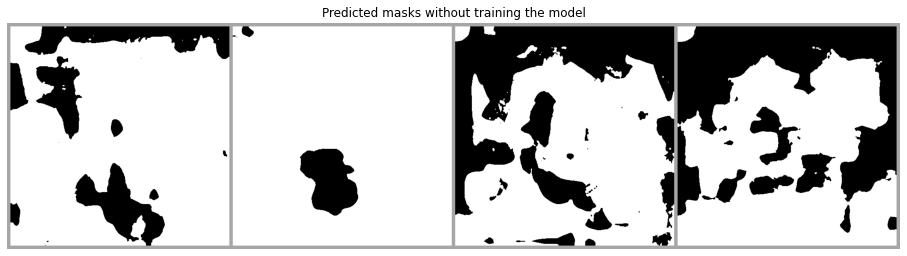

In [27]:
model.eval()
preds = torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu()
display_batch_masks(preds, caption=f'Predicted masks without training the model')
#plt.savefig("./assets/single-segmentation-overfitting-a-batch-without-training.png", dpi=300, bbox_inches='tight')

In [28]:
n_epochs = 350
eval_steps=10

# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_epochs)
cur_iou = []
for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities 
  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  cur_loss = loss.item()
  cur_iou.append(compute_intersection_over_union(logits.float(), yb.float()))
  lossi[idx] = cur_loss

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f} | mIoU: {np.mean(cur_iou):.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("Loss");

Random seed set as 42313988


  0%|          | 1/350 [00:00<05:16,  1.10it/s]

 -- Loss at epoch 0: 0.6968 | mIoU: 0.0000


  2%|▏         | 6/350 [00:05<04:55,  1.16it/s]

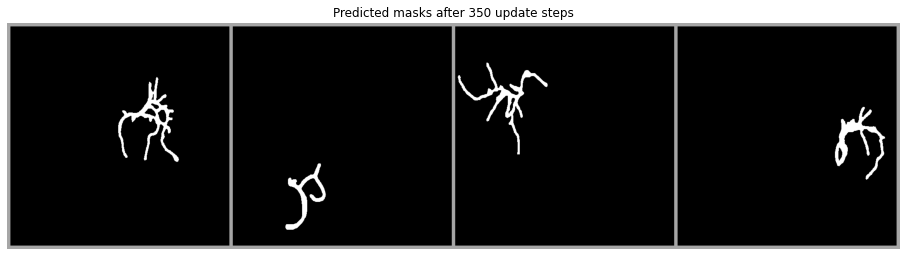

In [ ]:
model.eval()
logits = upscale_logits(model(xb)["logits"])
preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).unsqueeze(1).cpu()
display_batch_masks(preds, caption=f'Predicted masks after {n_epochs} update steps')
plt.savefig("./assets/single-segmentation-overfitting-a-batch.png", dpi=300, bbox_inches='tight')

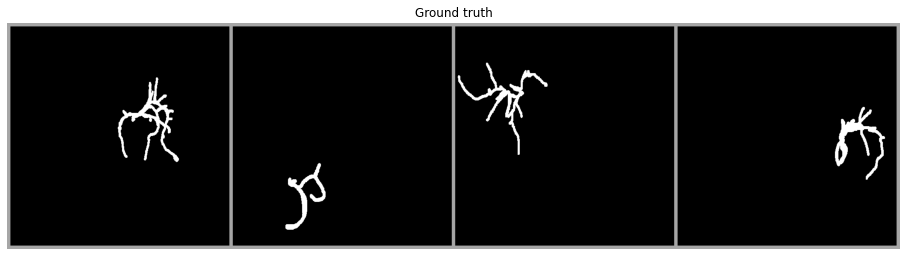

In [ ]:
display_batch_masks(yb.max(dim=1)[0].unsqueeze(1).cpu(), caption='Ground truth')
plt.savefig("./assets/single-segmentation-overfitting-a-batch-truth.png", dpi=300, bbox_inches='tight')

## Train on the entire dataset

In [3]:
set_seed(42313988)
# Hyperparameters --------------------------------------------------------------
lr = 1e-3           # learning rate
n_steps = 301       # number of steps to update the gradients
eval_steps=25       # evaluate every 10 epochs
BS = 2              # batch-size

# DataLoaders ------------------------------------------------------------------
val_pct = 0.15  # % of validation data
val_size= int(len(dataset) * val_pct)
train_size = len(dataset) - val_size
val_size, train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_set, batch_size=BS, 
                          shuffle=True, num_workers=0,
                          collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

val_loader = DataLoader(val_set, batch_size=BS, 
                        shuffle=False, num_workers=0,
                        collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

Random seed set as 42313988


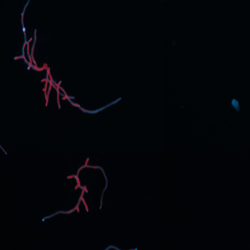

In [5]:
val_set[0]['image'].resize((250, 250))

In [6]:
# Model ----------------------------------------------------------------------- 
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

# Optimizer and loss function --------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_he

Random seed set as 42313988


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Saving a checkpoint...


  0%|          | 1/301 [00:04<21:55,  4.38s/it]

Checkpoint saved!
 -- Loss at epoch 0: 0.6795 | mIoU: 0.2418


  9%|▊         | 26/301 [00:28<08:46,  1.92s/it]

 -- Loss at epoch 25: 0.2259 | mIoU: 0.0000


 17%|█▋        | 51/301 [00:50<07:32,  1.81s/it]

 -- Loss at epoch 50: 0.0675 | mIoU: 0.0083


 25%|██▌       | 76/301 [01:14<06:30,  1.74s/it]

 -- Loss at epoch 75: 0.0593 | mIoU: 0.0323


 34%|███▎      | 101/301 [01:36<05:56,  1.78s/it]

 -- Loss at epoch 100: 0.0669 | mIoU: 0.1376


 42%|████▏     | 126/301 [01:58<05:01,  1.72s/it]

 -- Loss at epoch 125: 0.0338 | mIoU: 0.2345


 50%|█████     | 151/301 [02:21<04:11,  1.68s/it]

 -- Loss at epoch 150: 0.0462 | mIoU: 0.1219


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]t/s]


Saving a checkpoint...


 58%|█████▊    | 176/301 [02:44<03:45,  1.81s/it]

Checkpoint saved!
 -- Loss at epoch 175: 0.0644 | mIoU: 0.3841


 67%|██████▋   | 201/301 [03:07<03:00,  1.80s/it]

 -- Loss at epoch 200: 0.0298 | mIoU: 0.1884


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]t/s]


Saving a checkpoint...


 75%|███████▌  | 226/301 [03:29<02:10,  1.75s/it]

Checkpoint saved!
 -- Loss at epoch 225: 0.0331 | mIoU: 0.4368


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]t/s]


Saving a checkpoint...


 83%|████████▎ | 251/301 [03:52<01:33,  1.86s/it]

Checkpoint saved!
 -- Loss at epoch 250: 0.0223 | mIoU: 0.5258


 92%|█████████▏| 276/301 [04:15<00:41,  1.67s/it]

 -- Loss at epoch 275: 0.0505 | mIoU: 0.4245


100%|██████████| 301/301 [04:37<00:00,  1.08it/s]


 -- Loss at epoch 300: 0.0304 | mIoU: 0.5107
--- 277.4763605594635 seconds ---


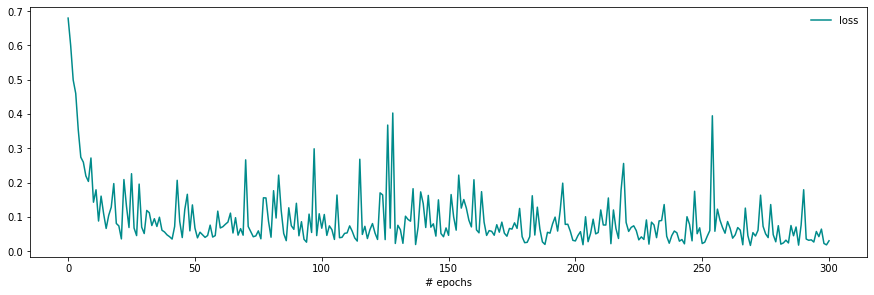

In [7]:
# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_steps)
miou = []
best_miou = -np.inf
for idx in tqdm(range(n_steps)):
  model.train()
  xb, yb = next(iter(train_loader))
  xb = xb.to(device)
  yb = yb.to(device)

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities 
  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  lossi[idx] = loss.item()

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    # Compute mean intersection over union in the valset
    val_preds, val_labels = get_pred_label(model, val_loader, device)
    miou.append(torch.mean(compute_iou(val_preds, val_labels)).item())

    if miou[-1] > best_miou:
      print("Saving a checkpoint...")
      best_miou = miou[-1]
      ckpt = {
          'steps': n_steps,
          'cur_steps': idx,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      torch.save(ckpt, './ckpt/single-segmentation.pth')
      print("Checkpoint saved!")
    # Print current loss and mIoU
    print(f" -- Loss at epoch {idx}: {lossi[idx]:.4f} | mIoU: {miou[-1]:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan", label="loss");
plt.xlabel("# epochs");
plt.legend(frameon=False);

## Load a checkpoint & compute metrics

**Important note:** the `set_seed()` must be equal in this block code
as well as in the training block code. Or you will mixing train and
validation examples in the metrics. This is not the best way to do it, but
you can ensure that the validation is correct looking the first example
image in the val set and comparing with the previous section.

In [4]:
set_seed(42313988)

# Hyperparameters --------------------------------------------------------------
lr = 1e-3           # learning rate
n_steps = 100       # number of steps to update the gradients
eval_steps=10       # evaluate every 10 epochs
BS = 2              # batch-size

# DataLoaders ------------------------------------------------------------------
val_pct = 0.15  # % of validation data
val_size= int(len(dataset) * val_pct)
train_size = len(dataset) - val_size
val_size, train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

val_loader = DataLoader(val_set, batch_size=BS, 
                        shuffle=False, num_workers=0,
                        collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

Random seed set as 42313988


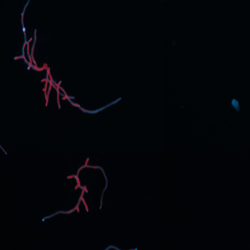

In [5]:
val_set[0]['image'].resize((250, 250))

In [6]:
# Model ----------------------------------------------------------------------- 
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

# Optimizer and loss function --------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Load the checkpoint
ckpt = torch.load('./ckpt/single-segmentation.pth')
model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.

Recover the mask predictions for the validation set.

In [7]:
preds, labels = get_pred_label(model, val_loader, device)
preds.shape, labels.shape

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


(torch.Size([10, 512, 512]), torch.Size([10, 512, 512]))

In [9]:
val_iou = compute_iou(preds, labels)
print(f"mean IoU on validation set: {torch.mean(val_iou):.4f}")

mean IoU on validation set: 0.5258


In [10]:
print("IoU per each validation example:\n")
val_iou

IoU per each validation example:



tensor([0.6895, 0.4673, 0.7664, 0.0026, 0.5333, 0.4500, 0.6005, 0.7132, 0.3637,
        0.6716])

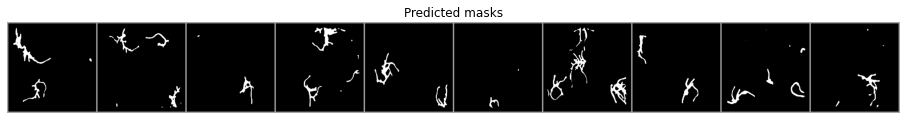

In [11]:
display_batch_masks(preds.unsqueeze(1), caption="Predicted masks")
#plt.savefig("./assets/best-miou-val-prediction-masks.png", dpi=320, bbox_inches='tight')

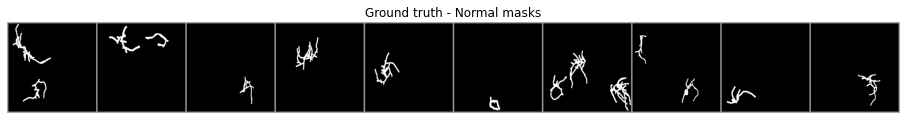

In [12]:
display_batch_masks(labels.unsqueeze(1), caption="Ground truth - Normal masks")
#plt.savefig("./assets/best-miou-val-truth-masks.png", dpi=320, bbox_inches='tight')

Let's zoom in the example with the highest IoU.

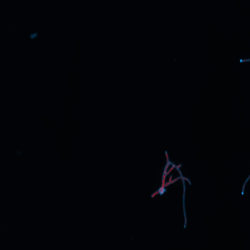

In [24]:
max_iou_idx = torch.argmax(val_iou).item()
val_set[max_iou_idx]['image'].resize((250, 250))

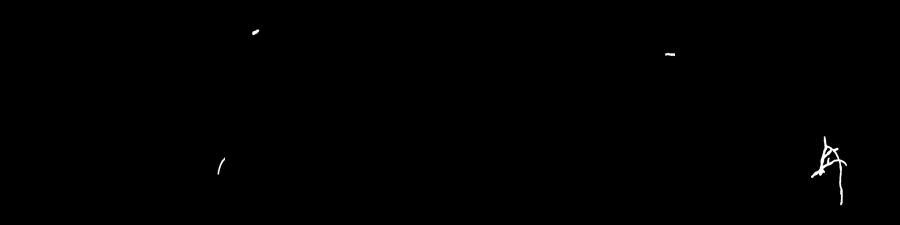

In [26]:
display_masks(val_set[max_iou_idx]['masks'])

The example is pretty simple in visual semantic, let's analyze now the
example with the lowest IoU.

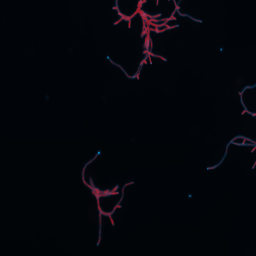

In [29]:
min_iou_idx = torch.argmin(val_iou).item()
val_set[min_iou_idx]['image'].resize((256, 256))

The ground truth mask doesn't match the image, but the prediction is pretty similar. 
We detect an example with a labelling problem in the dataset.

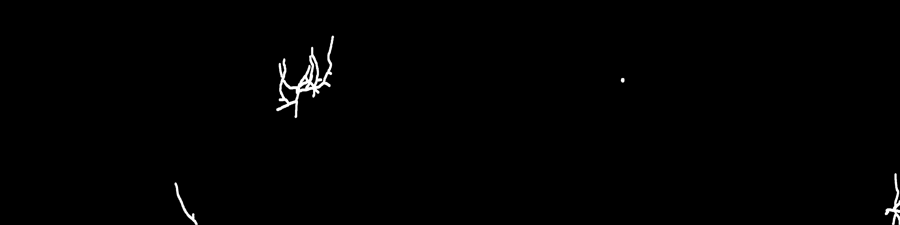

In [32]:
display_masks(val_set[min_iou_idx]['masks'])

### Precision, Recall, and PR-Curves

In [39]:
threshold = 0.5

TP = torch.sum(val_iou > threshold).item()
FP = val_iou.shape[0] - TP